In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd


class MF(nn.Module):
    def __init__(self, n_coeffs, n_comps, n_pix):
        super(MF, self).__init__()
        self.cfs = nn.Parameter(torch.rand(n_coeffs, n_comps, requires_grad=True))
        self.cmps = nn.Parameter(torch.rand(n_comps, n_pix, requires_grad=True))

    def forward(self):
        return torch.matmul(self.cfs,self.cmps)


def unit_norm(cmps):
    return torch.sum(torch.abs(torch.norm(cmps, dim=1) - (torch.ones(12)*20).to(device)))

ncomps = 12
λ = 1e-6
μ = 1e-7

cuda:0


nbart_red
nbart_green
nbart_blue
nbart_nir_1
nbart_nir_2
nbart_swir_2
nbart_swir_3


<BarContainer object of 7 artists>

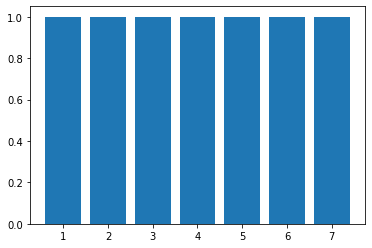

In [44]:
ds = xr.open_dataset(f"/data/pca_act/000_clean.nc")
ti_nan = (np.count_nonzero(np.isnan(ds.nbart_blue.values), axis=(1,2)))<.66*160000
ds = ds.isel(time=ti_nan)

stack = np.empty((0,400,400))
means = []
for fname in ds:
    print(fname)
    band = ds[fname]
    band = band.interpolate_na(dim='time')
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')
    stack = np.append(stack, band.values/band.values.mean(), axis=0)
    means.append(band.values.mean())

stack = stack.reshape(-1, 160000)# / 1e4

plt.bar(np.arange(1,8),np.mean(stack.reshape(7,71,160000),axis=(1,2)))

<BarContainer object of 7 artists>

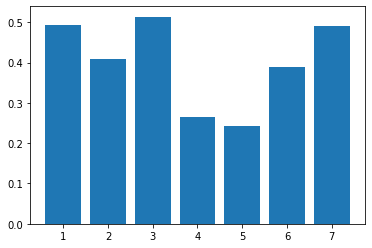

In [58]:
plt.bar(np.arange(1,8),np.std(stack.reshape(7,71,160000),axis=(1,2)))

In [41]:
means

[383.52902, 350.88297, 233.3073, 1951.0593, 2048.4233, 1392.0294, 781.0066]

<BarContainer object of 7 artists>

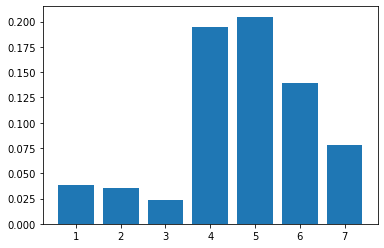

In [38]:
plt.bar(np.arange(1,8),np.mean((stack-stack_mean).reshape(7,71,160000),axis=(1,2)))

PCA MSE 12 comp 0.005304129879600502


<BarContainer object of 7 artists>

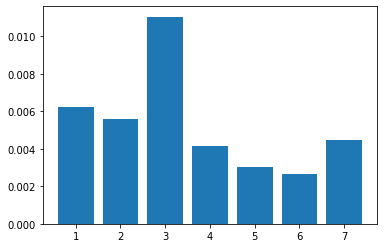

In [60]:
pca = PCA(n_components=20).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 12 comp", np.mean(np.square(pca_decomp - stack)))

err = np.mean(np.square(pca_decomp - stack).reshape(7,71,400,400),axis=(1,2,3))
plt.bar(np.arange(1,8),err)

In [62]:
red = stack.reshape(7,-1,160000)[5,:]
pca = PCA(n_components=12).fit(red)
coeffs = pca.transform(red)
red_decomp = pca.inverse_transform(coeffs)

np.mean(np.square(red_decomp - red))

0.0012742098043984195

In [26]:
pca = PCA(n_components=ncomps).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 12 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=11).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 11 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=10).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 10 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=9).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 9 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=8).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 8 comp", np.mean(np.square(pca_decomp - stack)))

PCA MSE 12 comp 5.552699591966187e-05
PCA MSE 11 comp 5.9733305171602925e-05
PCA MSE 10 comp 6.468225507122247e-05
PCA MSE 9 comp 6.986040641016541e-05
PCA MSE 8 comp 7.656027257432712e-05


0 2994.22509765625 9.778436660766602 2544.5703125
100 1227.8251953125 0.008826596662402153 871.3860473632812
200 1197.7841796875 0.007786229718476534 946.1788330078125
300 1196.3770751953125 0.0077525959350168705 956.20458984375
400 1198.5445556640625 0.00774427829310298 959.1441650390625
500 1200.558837890625 0.007739427033811808 960.8511962890625
600 1202.217041015625 0.007736263796687126 962.11962890625
700 1203.6270751953125 0.0077340384013950825 963.1377563476562
800 1204.839599609375 0.0077323904260993 963.9862060546875
900 1205.958251953125 0.007731123361736536 964.7102661132812
0.007730123121291399 0.0
0 6187.4970703125 0.007730123121291399 1.8576278686523438
100 6183.33740234375 0.007724418304860592 2.644390106201172
200 6179.1357421875 0.007724417373538017 2.8067760467529297
300 6175.0947265625 0.007724417373538017 2.959321975708008
400 6171.18115234375 0.007724418304860592 3.1051597595214844
500 6167.380859375 0.00772441690787673 3.24554443359375
600 6163.6845703125 0.007724

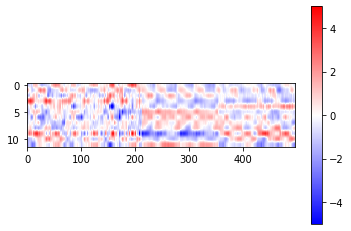

In [63]:
stack_mean = np.mean(stack, axis=0)
target = torch.from_numpy(stack-stack_mean).float().to(device)

ncoeffs = stack.shape[0]
npix = 160000

net = MF(ncoeffs, ncomps, npix)
net.to(device)

mse = nn.MSELoss(reduction='mean')

opt = optim.AdamW(net.parameters(), lr=1.0)

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20


opt = optim.AdamW(net.parameters(), lr=0.001)

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    if epoch == 0:
        print(loss.item(), unit_norm(net.cmps).item())

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20

cfs = net.cfs.detach().cpu().numpy()
print("cfs size:", cfs.shape, cfs.size)
print("Zeros before:", np.sum(np.isclose(cfs, np.zeros(cfs.shape), rtol=1e-03, atol=1e-04)))
print(f"Zeros after: 0.1->{np.sum(np.abs(cfs)<0.1)} 0.01->{np.sum(np.abs(cfs)<0.01)} 0.001->{np.sum(np.abs(cfs)<0.001)} 0.0001->{np.sum(np.abs(cfs)<0.0001)} 0.00001->{np.sum(np.abs(cfs)<0.00001)} 0.000001->{np.sum(np.abs(cfs)<0.000001)} 0.0000001->{np.sum(np.abs(cfs)<0.0000001)}")

plt.imshow(cfs.T, vmin=-5.0, vmax=5.0, aspect=10, cmap='bwr')
plt.colorbar()

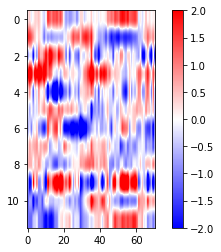

In [64]:

b = 1
plt.imshow(cfs[b*71:(b+1)*71].T, vmin=-2.0, vmax=2.0, aspect=10, cmap='bwr')
plt.colorbar()

<BarContainer object of 7 artists>

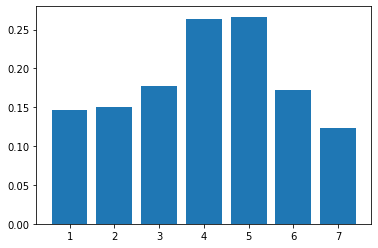

In [22]:
plt.bar(np.arange(1,8), np.abs(cfs.reshape(7,71,12)).mean(axis=(1,2)))

In [15]:
yhat = net()
yh = (yhat.detach().cpu().numpy()+stack_mean).reshape(7,71,400,400)
y = stack.reshape(7,71,400,400)

<BarContainer object of 7 artists>

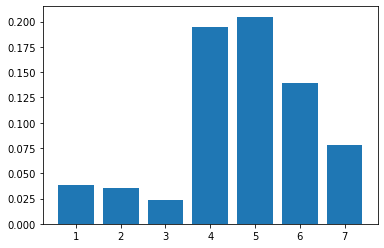

In [24]:
plt.bar(np.arange(1,8),(stack.reshape(7,71,400,400)).mean(axis=(1,2,3)))

<BarContainer object of 7 artists>

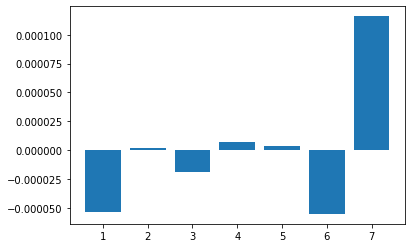

In [20]:
err = (yh-y).mean(axis=(1,2,3))
plt.bar(np.arange(1,8),err)